<a href="https://colab.research.google.com/github/romellfudi/PERU_CBI/blob/main/Cerebellar_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install watermark for copyright {display-mode: "form"}
!pip install -q watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


In [ ]:
%load_ext watermark
from IPython.display import clear_output
clear_output()
%watermark -a "Romell D.Z.(@romellfudi) Software Engineer, Business Intelligence Analist and Data Scientist" -iv  -u -d

Author: Romell D.Z.(@romellfudi) Software Engineer, Business Intelligence Analist and Data Scientist

Last updated: 2024-02-26




The content of this notebook was derived from Romell Dominguez's work, which can be found at https://github.com/romellfudi/PERU_CBI. The code was applied to address questions that were distinct from the ones investigated in the original study.

# Environment Set-up


Initially, we'll configure our notebook environment by installing the necessary packages. If you're using Google Colab, this step will ensure that the required packages are installed.



In [ ]:
%%capture

!pip install -q matplotlib pandas numpy scipy seaborn mne

In [ ]:
%%capture

!pip install -q beautifulsoup4 requests wget

In [ ]:
%%capture

!pip install -q h5py tables kaggle

In [ ]:
%%capture

!pip install -q wfdb pyEDFlib

In [1]:
# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}

# Peruvian Database


# Data Information

In [ ]:
import wfdb
import os
from urllib.request import urlretrieve

# Get unique participant codes from the 'chbmit' database
participant_codes = sorted(set(record.split('/')[0] for record in wfdb.io.get_record_list('chbmit', records='all')))

def download_and_read_summary(participant_code):
    url = f"https://raw.githubusercontent.com/romellfudi/PERU_CBI/main/{participant_code}-summary.txt"
    filename = f"./{participant_code}_summary.txt"
    urlretrieve(url, filename)
    with open(filename, encoding='UTF-8') as file:
        content = file.readlines()
    os.remove(filename)
    return content

# Display the summary for the third participant
participant_summary = download_and_read_summary(participant_codes[2])
print(participant_codes[2])
print("".join(participant_summary).strip())


chb03
Data Sampling Rate: 256 Hz
*************************

Channels in EDF Files:
**********************
Channel 1: FP1-F7
Channel 2: F7-T7
Channel 3: T7-P7
Channel 4: P7-O1
Channel 5: FP1-F3
Channel 6: F3-C3
Channel 7: C3-P3
Channel 8: P3-O1
Channel 9: FP2-F4
Channel 10: F4-C4
Channel 11: C4-P4
Channel 12: P4-O2
Channel 13: FP2-F8
Channel 14: F8-T8
Channel 15: T8-P8
Channel 16: P8-O2
Channel 17: FZ-CZ
Channel 18: CZ-PZ
Channel 19: P7-T7
Channel 20: T7-FT9
Channel 21: FT9-FT10
Channel 22: FT10-T8
Channel 23: T8-P8

File Name: chb03_01.edf
File Start Time: 13:23:36
File End Time: 14:23:36
Number of Seizures in File: 1
Seizure Start Time: 362 seconds
Seizure End Time: 414 seconds

File Name: chb03_02.edf
File Start Time: 14:23:39
File End Time: 15:23:39
Number of Seizures in File: 1
Seizure Start Time: 731 seconds
Seizure End Time: 796 seconds

File Name: chb03_03.edf
File Start Time: 15:23:47
File End Time: 16:23:47
Number of Seizures in File: 1
Seizure Start Time: 432 seconds
Seizure 

Now we convert the files into dictionaries

In [ ]:
import re

# Dictionary to store participant information
participant_info = {}

def process_file_info(content):
    total_lines = len(content)
    line_number = 1

    channels = []
    file_name = None
    file_info = {}

    for line in content:
        # Extract channel information
        if re.findall('Channel \d+', line):
            channel = line.split(': ')[-1].strip()
            channels.append(channel)

        # Extract file name and initialize file info
        elif re.findall('File Name', line):
            if file_name is not None:
                participant_info[file_name] = file_info
            file_name = re.findall('\w+\d+_\d+|\w+\d+\w+_\d+', line)[0]
            file_info = {'Channels': list(set(channels)), 'Start': '', 'End': '', 'Seizure_Window': []}

        # Extract file start time
        elif re.findall('File Start Time', line):
            file_info['Start'] = re.findall('\d+:\d+:\d+', line)[0]

        # Extract file end time
        elif re.findall('File End Time', line):
            file_info['End'] = re.findall('\d+:\d+:\d+', line)[0]

        # Extract seizure window times
        elif re.findall('Seizure Start Time|Seizure End Time|Seizure \d+ Start Time|Seizure \d+ End Time', line):
            file_info['Seizure_Window'].append(int(re.findall('\d+', line)[-1]))

        # Store file info at the last line
        if line_number == total_lines:
            participant_info[file_name] = file_info

        line_number += 1

# Process each participant's summary content
for participant_code in participant_codes:
    participant_content = download_and_read_summary(participant_code)
    process_file_info(participant_content)

# Print the resulting dictionary
print(participant_info)


{'chb01_01': {'Channels': ['P7-T7', 'T8-P8', 'P7-O1', 'P8-O2', 'FT9-FT10', 'C3-P3', 'CZ-PZ', 'FZ-CZ', 'F3-C3', 'T7-FT9', 'FP2-F8', 'P4-O2', 'FT10-T8', 'FP1-F3', 'P3-O1', 'T7-P7', 'C4-P4', 'F8-T8', 'F4-C4', 'FP1-F7', 'F7-T7', 'FP2-F4'], 'Start': '11:42:54', 'End': '12:42:54', 'Seizure_Window': []}, 'chb01_02': {'Channels': ['P7-T7', 'T8-P8', 'P7-O1', 'P8-O2', 'FT9-FT10', 'C3-P3', 'CZ-PZ', 'FZ-CZ', 'F3-C3', 'T7-FT9', 'FP2-F8', 'P4-O2', 'FT10-T8', 'FP1-F3', 'P3-O1', 'T7-P7', 'C4-P4', 'F8-T8', 'F4-C4', 'FP1-F7', 'F7-T7', 'FP2-F4'], 'Start': '12:42:57', 'End': '13:42:57', 'Seizure_Window': []}, 'chb01_03': {'Channels': ['P7-T7', 'T8-P8', 'P7-O1', 'P8-O2', 'FT9-FT10', 'C3-P3', 'CZ-PZ', 'FZ-CZ', 'F3-C3', 'T7-FT9', 'FP2-F8', 'P4-O2', 'FT10-T8', 'FP1-F3', 'P3-O1', 'T7-P7', 'C4-P4', 'F8-T8', 'F4-C4', 'FP1-F7', 'F7-T7', 'FP2-F4'], 'Start': '13:43:04', 'End': '14:43:04', 'Seizure_Window': [2996, 3036]}, 'chb01_04': {'Channels': ['P7-T7', 'T8-P8', 'P7-O1', 'P8-O2', 'FT9-FT10', 'C3-P3', 'CZ-PZ', 'FZ

In [ ]:
download_and_read_summary(participant_code_to_download)

['Data Sampling Rate: 256 Hz\n',
 '*************************\n',
 '\n',
 'Channels in EDF Files:\n',
 '**********************\n',
 'Channel 1: FP1-F7\n',
 'Channel 2: F7-T7\n',
 'Channel 3: T7-P7\n',
 'Channel 4: P7-O1\n',
 'Channel 5: FP1-F3\n',
 'Channel 6: F3-C3\n',
 'Channel 7: C3-P3\n',
 'Channel 8: P3-O1\n',
 'Channel 9: FP2-F4\n',
 'Channel 10: F4-C4\n',
 'Channel 11: C4-P4\n',
 'Channel 12: P4-O2\n',
 'Channel 13: FP2-F8\n',
 'Channel 14: F8-T8\n',
 'Channel 15: T8-P8\n',
 'Channel 16: P8-O2\n',
 'Channel 17: FZ-CZ\n',
 'Channel 18: CZ-PZ\n',
 'Channel 19: P7-T7\n',
 'Channel 20: T7-FT9\n',
 'Channel 21: FT9-FT10\n',
 'Channel 22: FT10-T8\n',
 'Channel 23: T8-P8\n',
 '\n',
 'File Name: chb03_01.edf\n',
 'File Start Time: 13:23:36\n',
 'File End Time: 14:23:36\n',
 'Number of Seizures in File: 1\n',
 'Seizure Start Time: 362 seconds\n',
 'Seizure End Time: 414 seconds\n',
 '\n',
 'File Name: chb03_02.edf\n',
 'File Start Time: 14:23:39\n',
 'File End Time: 15:23:39\n',
 'Number 


Below, it is evident that there is a shared group of channels present in every patient. However, there are also channels unique to specific individuals, which can be attributed to occasional substitutions of channels during the recording process.

In [ ]:
import pandas as pd  # For working with dataframes
import re

# Collect all channels from participant information
all_channels = []
for key in participant_info.keys():
    all_channels.extend(participant_info[key]['Channels'])

# Count occurrences of each channel
all_channels = pd.Series(all_channels)
channel_counts = all_channels.value_counts()

# Display channel counts
print(channel_counts)


P4-O2      675
FP1-F3     675
FP2-F4     675
F7-T7      675
FP1-F7     675
          ... 
CZ          13
P8          13
F3          13
F8          13
LOC-ROC     11
Length: 87, dtype: int64


In [ ]:
threshold = len(participant_info.keys())
channels_to_keep = list(channel_counts[channel_counts >= threshold].index)
channels_to_keep

['P4-O2',
 'FP1-F3',
 'FP2-F4',
 'F7-T7',
 'FP1-F7',
 'F4-C4',
 'F8-T8',
 'C4-P4',
 'T7-P7',
 'P3-O1',
 'T8-P8',
 'FP2-F8',
 'F3-C3',
 'FZ-CZ',
 'CZ-PZ',
 'C3-P3',
 'P8-O2',
 'P7-O1']

In [ ]:
# Set EXAMPLE_FILE to the file at index 17 in records_list.
EXAMPLE_FILE = records_list[17]

# Extract EXAMPLE_ID from EXAMPLE_FILE.
EXAMPLE_ID = EXAMPLE_FILE.split('/')[1].split('.')[0]

# Display EXAMPLE_ID.
EXAMPLE_ID

'chb03_34'

Now using the function below I can download the data and then load it into a pandas dataframe

In [ ]:
%%time
import pandas as pd
import numpy as np
import pyedflib
import os
from urllib.request import urlretrieve

def load_data(file, selected_channels=[]):
    try:
        # Download the EDF file
        url = "https://physionet.org/physiobank/database/chbmit/" + file
        file_name = "./chbmit.edf"
        urlretrieve(url, file_name)

        # Read the EDF file
        edf_file = pyedflib.EdfReader(file_name)
        os.remove(file_name)

        # Use all channels if none are specified
        if len(selected_channels) == 0:
            selected_channels = edf_file.getSignalLabels()

        # Get channel names and sampling frequencies
        channel_names = edf_file.getSignalLabels()
        channel_frequencies = edf_file.getSampleFrequencies()

        # Initialize an array to store signal data
        signal_buffers = np.zeros((edf_file.getNSamples()[0], len(selected_channels)))

        # Extract data for selected channels
        for i, channel in enumerate(selected_channels):
            signal_buffers[:, i] = edf_file.readSignal(channel_names.index(channel))

        # Convert signal data to a pandas DataFrame
        df = pd.DataFrame(signal_buffers, columns=selected_channels).astype('float32')

        # Create a time index based on sampling frequency
        index_increase = np.linspace(0, len(df) / channel_frequencies[0], len(df), endpoint=False)
        seconds = index_increase

        # Set time as the index
        df['Time'] = seconds
        df = df.set_index('Time')
        df.columns.name = 'Channel'

        return df, channel_frequencies[0]

    except:
        # Handle errors gracefully
        return pd.DataFrame(), None

# Load data for the example file and display the first few rows
raw_data, frequency = load_data(EXAMPLE_FILE, channels_to_keep)
display(raw_data.head())


256.0
[0.00000000e+00 3.90625000e-03 7.81250000e-03 ... 3.59998828e+03
 3.59999219e+03 3.59999609e+03]


Channel,P4-O2,FP1-F3,FP2-F4,F7-T7,FP1-F7,F4-C4,F8-T8,C4-P4,T7-P7,P3-O1,T8-P8,FP2-F8,F3-C3,FZ-CZ,CZ-PZ,C3-P3,P8-O2,P7-O1
Time,,,,,,,,,,,,,,,,,,
0.000000,-75.213676,51.770451,50.598289,63.492062,35.360195,25.982906,104.908424,-116.630035,-6.837607,35.750916,0.976801,-28.717949,11.916972,-44.346764,18.949940,8.791209,-192.429794,16.214897
0.003906,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360
0.007812,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,-0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,-0.195360,0.195360,-0.586081,0.195360
0.011719,-2.930403,0.195360,0.195360,0.586081,-0.195360,0.195360,2.148962,-3.711844,0.195360,0.195360,-0.195360,-1.758242,0.195360,-0.586081,-1.758242,-0.195360,-6.837607,0.195360
0.015625,-1.758242,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,1.367521,0.195360,0.195360,0.195360,0.195360,0.195360,0.586081,1.758242,0.195360,-0.195360,0.195360


CPU times: user 1.01 s, sys: 726 ms, total: 1.73 s
Wall time: 51.5 s


# Graph the data

Creating RawArray with float64 data, n_channels=18, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


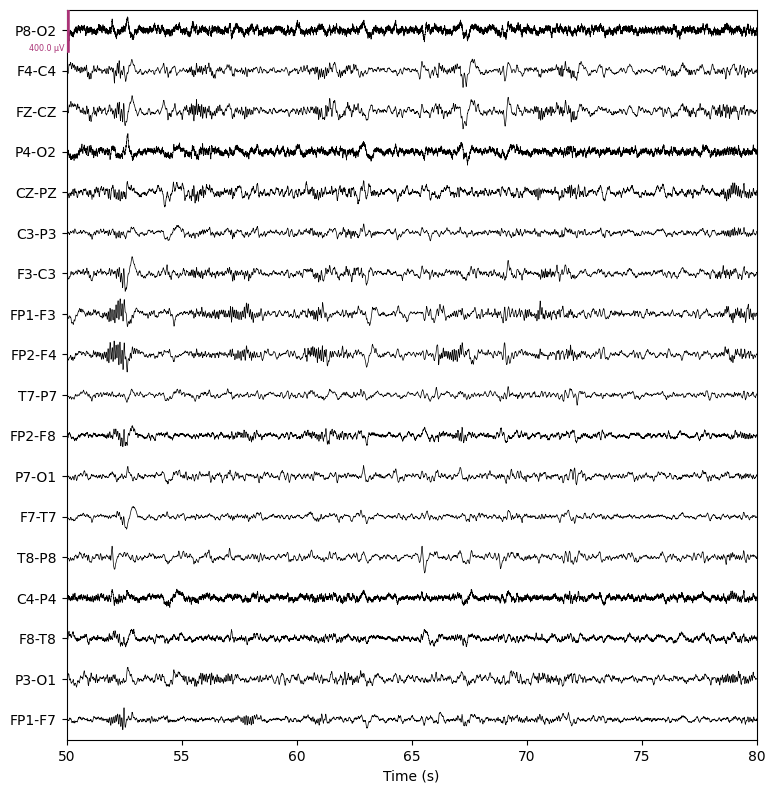

Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



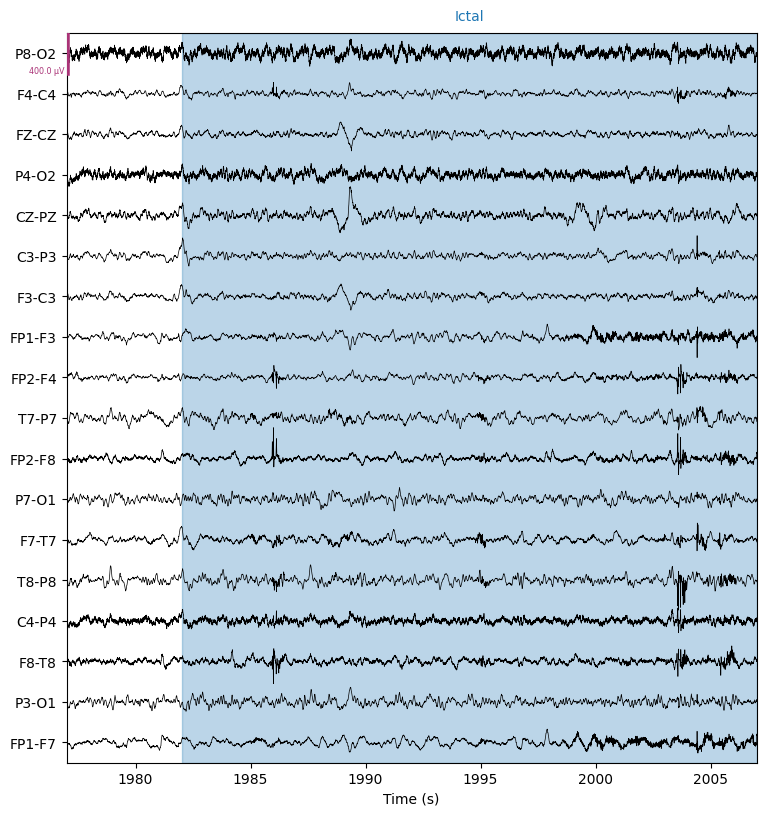

In [ ]:
import mne

def create_mne_object(data, frequency, events=None):
    # Create MNE info with channel names, sampling frequency, and EEG channel type
    info = mne.create_info(ch_names=list(data.columns),
                           sfreq=frequency,
                           ch_types=['eeg'] * data.shape[-1])

    # Convert data from microvolts to volts and transpose it
    data = data.apply(lambda x: x * 1e-6)
    transposed_data = data.transpose()

    # Create MNE Raw object
    raw = mne.io.RawArray(transposed_data, info)

    # Add annotations for seizure events if provided
    if events:
        start_times = np.array(events[::2])
        end_times = np.array(events[1::2])
        annotation_length = end_times - start_times
        event_name = np.array(['Ictal'] * len(annotation_length))
        raw.set_annotations(mne.Annotations(start_times, annotation_length, event_name))

    return raw

# Create MNE object and plot EEG data
mne_data = create_mne_object(raw_data, frequency, participant_info[EXAMPLE_ID]['Seizure_Window'])
mne_data.plot(start=50, duration=30, **plot_kwargs)

# Plot EEG data around the seizure start time
seizure_start_time = participant_info[EXAMPLE_ID]['Seizure_Window'][0]
mne_data.plot(start=seizure_start_time - 5, duration=30, **plot_kwargs)


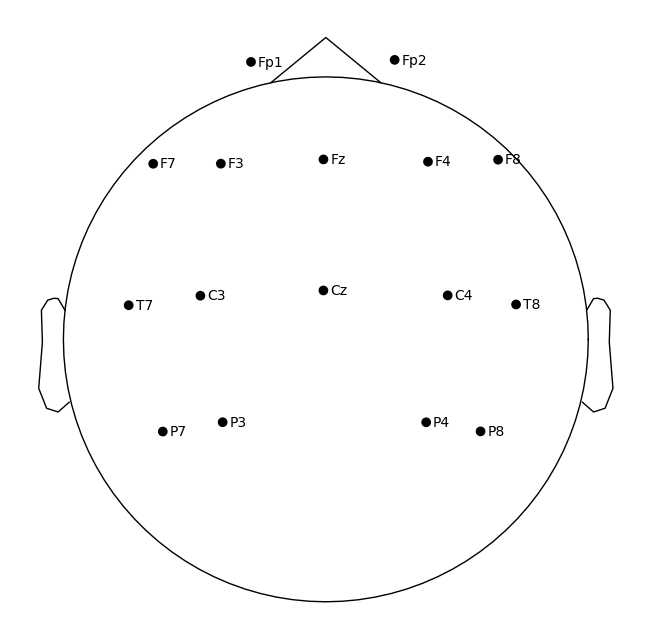

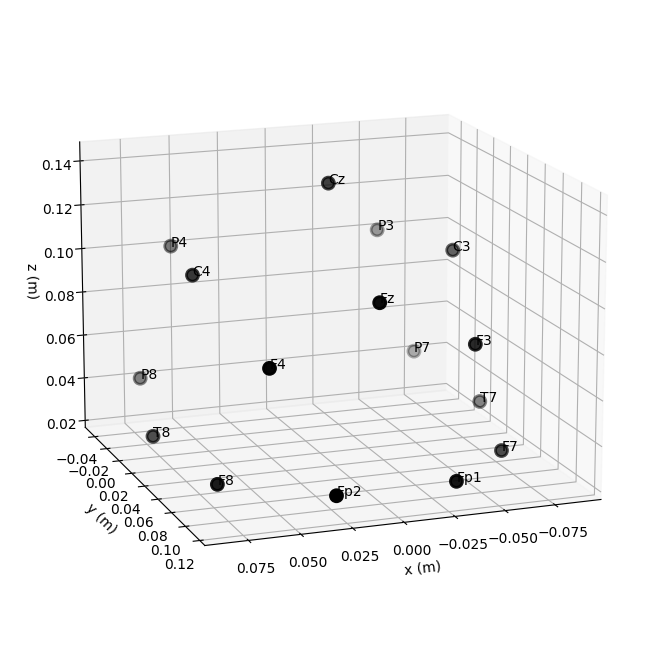

In [ ]:
import matplotlib.pyplot as plt

replacement_dict = {}
channels_to_remove = []

# Process channel names to avoid duplicates and standardize naming
for channel_name in mne_data.info['ch_names']:
    new_name = re.findall('\w+', channel_name)[0].title()
    if new_name in replacement_dict.values():
        channels_to_remove.append(channel_name)  # Mark duplicate channels for removal
    else:
        replacement_dict[channel_name] = new_name  # Map original to standardized name

# Remove duplicate channels and rename remaining ones
mne_data.drop_channels(channels_to_remove)
mne_data.rename_channels(replacement_dict)

# Apply standard montage and visualize sensor locations
mne_data.set_montage('standard_1020')
mne_data.plot_sensors(kind='topomap', show_names=True, to_sphere=True)
figure = mne_data.plot_sensors(kind='3d', show_names=True, show=False)
figure = figure.gca().view_init(azim=70, elev=15)
plt.show()


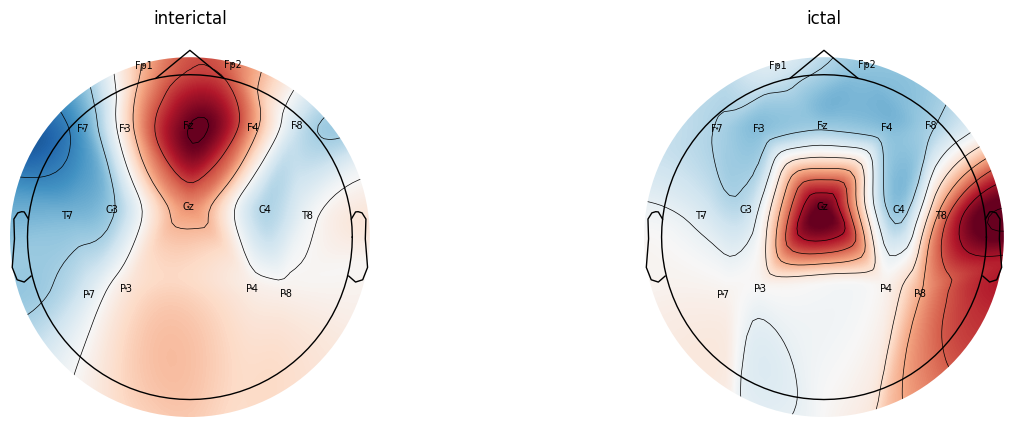

In [ ]:
from scipy import signal

# Convert frequency to integer
frequency = int(frequency)

# Function to calculate average power spectral density (PSD) in a specific frequency range
def average_frequency(data):
    window_size = 4 * frequency  # Define window size for Welch's method
    freqs, psd = signal.welch(data, frequency, nperseg=window_size, scaling='spectrum')
    return psd[:, 4:160].mean(1)  # Average PSD in the range of interest

# Extract interictal and ictal data segments
interictal_array = mne_data[:, 80*frequency:110*frequency][0]
ictal_array = mne_data[:, (seizure_start_time*frequency + 90*frequency):(seizure_start_time*frequency) + 120*frequency][0]

# Create a DataFrame with average frequency values for interictal and ictal states
topo_df = pd.DataFrame([average_frequency(interictal_array), average_frequency(ictal_array)], 
                       index=['interictal', 'ictal'])

# Plot topographic maps for interictal and ictal states
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.flatten()

for i, data_class in enumerate(topo_df.T):
    # Generate topographic map for each state
    topo, cn = mne.viz.plot_topomap(topo_df.loc[data_class],
                                    mne_data.info,
                                    show=False,
                                    sensors=True,
                                    names=mne_data.info['ch_names'],
                                    axes=axs[i],
                                    cmap='RdBu_r')
    axs[i].set_title(data_class)  # Set title for each subplot

plt.show()